In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt


In [35]:
# generating our dataset
image_size = (224, 224)
batch_size = 32

In [36]:
train = tf.keras.preprocessing.image_dataset_from_directory(
    "data/train",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2185 files belonging to 15 classes.


In [37]:
val = tf.keras.preprocessing.image_dataset_from_directory(
    "data/valid",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 75 files belonging to 15 classes.


In [38]:
# data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomContrast(0.5),
        layers.RandomZoom(0.3)
    ]
)

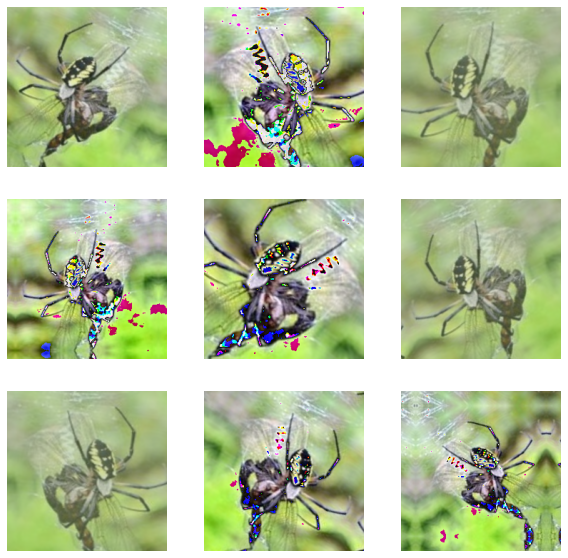

In [39]:
plt.figure(figsize=(10, 10))
for images, _ in train.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [7]:
train = train.prefetch(buffer_size=32)
val = val.prefetch(buffer_size=32)

In [47]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    
    activation = "softmax"
    
    outputs = layers.Dense(15, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=15)
keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [48]:
epochs = 10

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train, epochs=epochs, validation_data=val, steps_per_epoch=5,
)

Epoch 1/10
5/5 [==============================] - 48s 9s/step - loss: 2.7625 - accuracy: 0.1187 - val_loss: 2.7078 - val_accuracy: 0.0667
Epoch 2/10
5/5 [==============================] - 49s 10s/step - loss: 2.3784 - accuracy: 0.2812 - val_loss: 2.7077 - val_accuracy: 0.0667
Epoch 3/10
5/5 [==============================] - 54s 11s/step - loss: 2.4491 - accuracy: 0.2375 - val_loss: 2.7077 - val_accuracy: 0.0667
Epoch 4/10
5/5 [==============================] - 52s 11s/step - loss: 2.2455 - accuracy: 0.2812 - val_loss: 2.7080 - val_accuracy: 0.0933
Epoch 5/10
5/5 [==============================] - 50s 10s/step - loss: 2.2970 - accuracy: 0.3187 - val_loss: 2.7081 - val_accuracy: 0.0667
Epoch 6/10
5/5 [==============================] - 48s 10s/step - loss: 2.0451 - accuracy: 0.2937 - val_loss: 2.7092 - val_accuracy: 0.0667
Epoch 7/10
5/5 [==============================] - 56s 12s/step - loss: 2.2162 - accuracy: 0.3438 - val_loss: 2.7121 - val_accuracy: 0.0667
Epoch 8/10
5/5 [============

In [57]:
img = keras.preprocessing.image.load_img("data/test/Blue Tarantula/1.jpg", target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = predictions[0]
print(score)

[0.06772264 0.04152294 0.07152567 0.07615089 0.08926494 0.08250177
 0.0724185  0.08659994 0.06686587 0.06533079 0.06033286 0.04613283
 0.06456843 0.04510786 0.06395411]
